In [1]:
import sys
sys.path.append('modules/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from matplotlib.tri import Triangulation
import matplotlib
import figures as fg
import general_figures as gn
from itertools import repeat
from collections import defaultdict
import math
import warnings

sns.set_style('white')
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Load all the data, filter, rename, and bin

In [2]:
data = pd.read_pickle('data/averaged_chec_sumprom.gz')
TFS = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']

gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_check = data.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_waro = data
data_waro = data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
data_check = data.drop(aro_targets)

nuc_df = pd.read_csv('data/nucleosomes_df_perprom700bp.csv', index_col=0)
rna_nonlibs = pd.read_pickle('data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0)
facs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0).loc['facs']
by_rna = pd.read_csv('data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]

#Looking only on relevant genes
rna_nonlibs = rna_nonlibs.loc[bins.index]
rna_libs = rna_libs.loc[bins.index]
by_rna_median = by_rna_median.loc[bins.index]
rna_libs = pd.concat([rna_libs,pd.DataFrame(facs).transpose()], axis=0)
data_check = data_check.loc[bins.drop(['MNASE', 'SPL2', 'NAF1', 'ESBP6', 'SDH6']).index]
rna_libs.columns = [name.replace('Parent', 'nativeprom') for name in rna_libs.columns.values]
facs.index = [name.replace('Parent', 'nativeprom') for name in facs.index.values]


opn = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan
opn = gn.prepare_opn(opn).loc[bins.index[:-1]]



all_tfs = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3', 'Vhr1',
 'Nrg2',
 'Pdr8',
 'Abf1',
 'Crz1',
 'Gln3',
 'Reb1',
 'Met31',
 'Rpn4',
 'Sko1',
 'Cst6']


lab_dat = data_waro.filter(regex='|'.join(all_tfs)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_check.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)

lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]
lab_dat.columns = [name+'_lab_data' for name in lab_dat.columns.values]

nonlibs_tef_data = [fg.get_nonlib_data(tf,rna_nonlibs, data_waro, 'nodeletion_tef') for tf in all_tfs]
nonlibs_tef_rna = pd.concat([data[1] for data in nonlibs_tef_data], axis=1).sub(by_rna_median.values, axis=0).loc[bins.index]
nonlibs_tef_rna = pd.concat([nonlibs_tef_rna.filter(regex=i) for i in ['Full', 'Gal4AD', 'Gcn4AD']], axis=1)
nonlibs_tef_binding = gn.get_zscored(pd.concat([data[0] for data in nonlibs_tef_data], axis=1))
nonlibs_tef_binding = pd.concat([gn.get_zscored(data_waro).loc[:, 'Rpn4Full_dRpn4_deletions_tef_3_reps_0.95_meancorr'], nonlibs_tef_binding], axis=1)
nonlibs_tef_binding = pd.concat([gn.get_zscored(lab_dat.filter(regex=''.join(['^{}|'.format(tf) for tf in all_tfs])[:-1])), nonlibs_tef_binding], axis=1)

nonlibs_tef_binding_raw = pd.concat([data[0] for data in nonlibs_tef_data], axis=1)
nonlibs_tef_binding_raw = pd.concat([data_waro.loc[:, 'Rpn4Full_dRpn4_deletions_tef_3_reps_0.95_meancorr'], nonlibs_tef_binding_raw], axis=1)
nonlibs_tef_binding_raw = pd.concat([lab_dat.filter(regex=''.join(['^{}|'.format(tf) for tf in all_tfs])[:-1]), nonlibs_tef_binding_raw], axis=1)

bins_std = nonlibs_tef_rna.groupby(bins).std()
bins_mean = nonlibs_tef_rna.groupby(bins).mean()
get_zs = lambda x: nonlibs_tef_rna.loc[bins[bins == x].index].sub(bins_mean.loc[x]).div(bins_std.loc[x])
zs_fc_alltfs = pd.concat(map(get_zs, range(10))).loc[data_waro.index]


# Non general functions for the fig1

In [3]:
def kdeplot(ax, activated, wt_targets,  title):
    ax[0].set_title(title)
    sns.kdeplot(activated.drop(wt_targets.loc['Msn2_lab_data'].values[0]), ax=ax[0],
                bw_adjust=0.8, alpha=1, fill=True, color='gainsboro',linewidth=1, edgecolor='k')
    sns.kdeplot(activated.loc[wt_targets.loc['Msn2_lab_data'].values[0]], ax=ax[1],
                bw_adjust=0.8, alpha=.5, fill=True, color='saddlebrown',linewidth=1, edgecolor='k')
    
def triang(all_aff_df,fig):
    M = 1
    N = all_aff_df.shape[1]
    x = np.arange(M + 1)
    y = np.arange(N + 1)
    xs, ys = np.meshgrid(x, y)

    triangles2 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triangles1 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]

    triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)
    triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
    vmax=.4

    cmap1= 'Purples'
    cmap2= 'Oranges'
    img1 = ax[0].tripcolor(triang1, all_aff_df.iloc[1,:].values, cmap=cmap1,
                           vmax=vmax, edgecolors='k',linewidths=1)
    img2 = ax[0].tripcolor(triang2, all_aff_df.iloc[0,:].values, cmap=cmap2,
                           vmax=vmax, edgecolors='k',linewidths=1)

    img1 = ax[1].tripcolor(triang1, all_aff_df.iloc[3,:].values, cmap=cmap1, vmax=vmax, edgecolors='k',linewidths=1)
    img2 = ax[1].tripcolor(triang2, all_aff_df.iloc[2,:].values, cmap=cmap2, vmax=vmax, edgecolors='k',linewidths=1)


    img1 = ax[2].tripcolor(triang1, all_aff_df.iloc[5,:].values, cmap=cmap1, vmax=vmax, edgecolors='k',linewidths=1)
    img2 = ax[2].tripcolor(triang2, all_aff_df.iloc[4,:].values, cmap=cmap2, vmax=vmax, edgecolors='k',linewidths=1)

    cax = fig.add_axes([0.22, .9, 0.25, 0.01])
    cax2 = fig.add_axes([0.62, .9, 0.25, 0.01])

    fig.colorbar(img2,  cax=cax, orientation='horizontal')
    fig.colorbar(img1, cax=cax2, orientation='horizontal')
    for axi in ax:
        axi.set_xlim(x[0], x[-1])
        axi.set_ylim(y[0], y[-1])

    ax[0].set_yticks(y[:-1]+0.5,labels=(all_aff_df.columns.values), rotation=0)
    ax[1].set_yticklabels('')
    ax[2].set_yticklabels('')
    ax[1].set_xticklabels('')
    ax[2].set_xticklabels('')
    ax[0].set_xticklabels('')

    for i in range(1,all_aff_df.shape[1]+1):
        ax[0].text(0.15,i-.8,'{}%'.format(np.round(all_aff_df.iloc[0,:].values[i-1]*100,1)))
        ax[0].text(0.53,i-.3,'{}%'.format(np.round(all_aff_df.iloc[1,:].values[i-1]*100,1)))
        ax[1].text(0.15,i-.8,'{}%'.format(np.round(all_aff_df.iloc[2,:].values[i-1]*100,1)))
        ax[1].text(0.53,i-.3,'{}%'.format(np.round(all_aff_df.iloc[3,:].values[i-1]*100,1)))
        ax[2].text(0.15,i-.8,'{}%'.format(np.round(all_aff_df.iloc[4,:].values[i-1]*100,1)))
        ax[2].text(0.53,i-.3,'{}%'.format(np.round(all_aff_df.iloc[5,:].values[i-1]*100,1)))

    ax[0].set_xlabel('Full')
    ax[1].set_xlabel('Gal4AD')
    ax[2].set_xlabel('Gcn4AD')


    secax = ax[2].secondary_yaxis('right')
    secax.set_yticklabels(wt_targets.loc[[name + '_lab_data' for name in order]].applymap(lambda x:len(x)).WT.values)
    secax.set_yticks(np.arange(0.5,16, 1))
    secax.set_ylabel('Num of targets')
    
    
def subset(wt, d):
    sub_d = defaultdict(dict)
    for i,k in d.items():
        sub_d[i.split('nodeletion')[0][:-1]]['unique'] = list(set(k).difference(wt))
    return sub_d
count = lambda x: len(x)

# Fig1D

C:\Users\vovam\AppData\Local\Temp\ipykernel_22492\832257072.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\vovam\AppData\Local\Temp\ipykernel_22492\832257072.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  secax.set_xticklabels([k[0].shape[0] for k in wt_targets.values])


Text(0.5, 0, 'Num of target promoters \n 672 unique promoters')

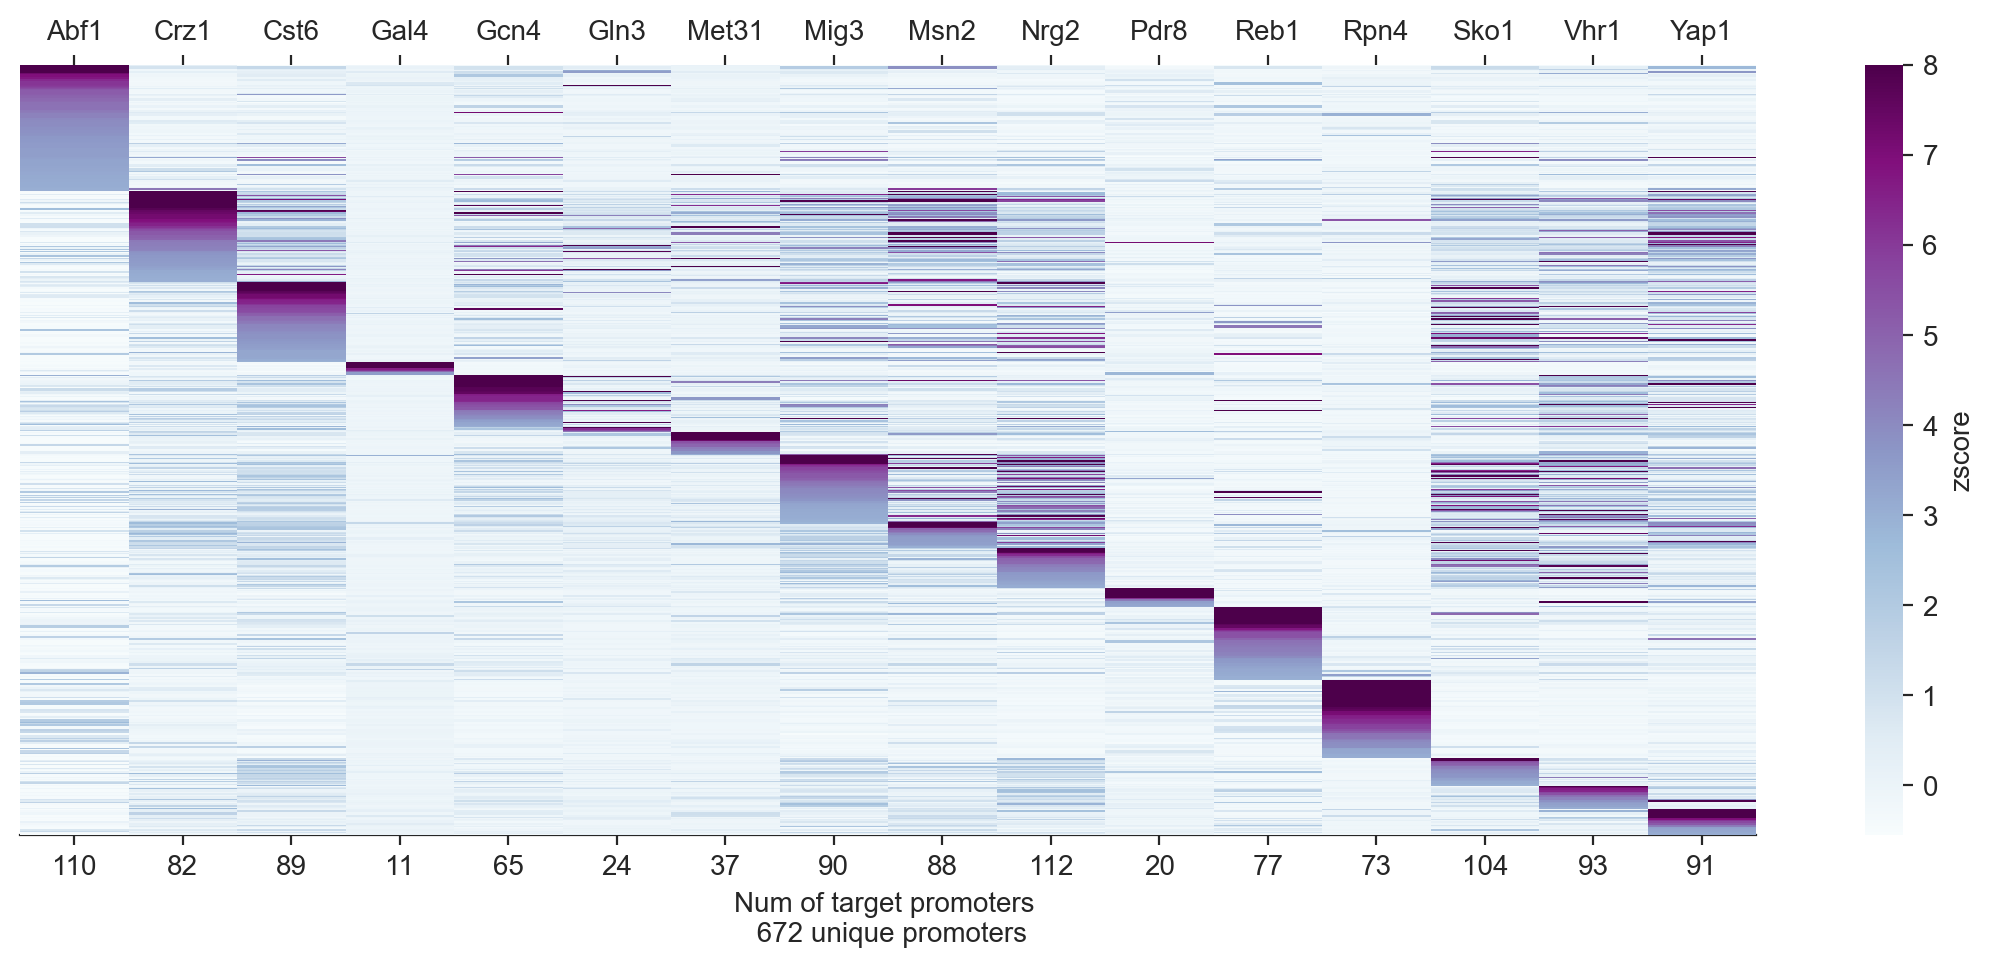

In [4]:
wt_targets = fg.get_targets_df(lab_dat.sort_index(axis=1),3,'WT',opn, '')
all_targets_index = pd.Index(np.concatenate(np.concatenate(wt_targets.values))).drop_duplicates()
lab_zscores = gn.get_zscored(lab_dat).loc[all_targets_index, :].sort_index(axis=1)

fig, ax = plt.subplots(1, figsize=(14,5))
sns.heatmap(lab_zscores.loc[all_targets_index], vmax=8, cmap='BuPu', yticklabels=False, ax=ax, cbar_kws={'label':'zscore'})
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_xticklabels([name.split('_')[0] for name in lab_zscores.columns.values])
fig.show()
secax = ax.secondary_xaxis('bottom')
secax.set_xticklabels([k[0].shape[0] for k in wt_targets.values])
secax.set_xticks(np.arange(0.5,16, 1))
secax.set_xlabel('Num of target promoters \n {} unique promoters'.format(len(all_targets_index)))

# fig.savefig('newtext_figs/fig1/proms.pdf', bbox_inches = 'tight', transparent=True)

# Fig1E

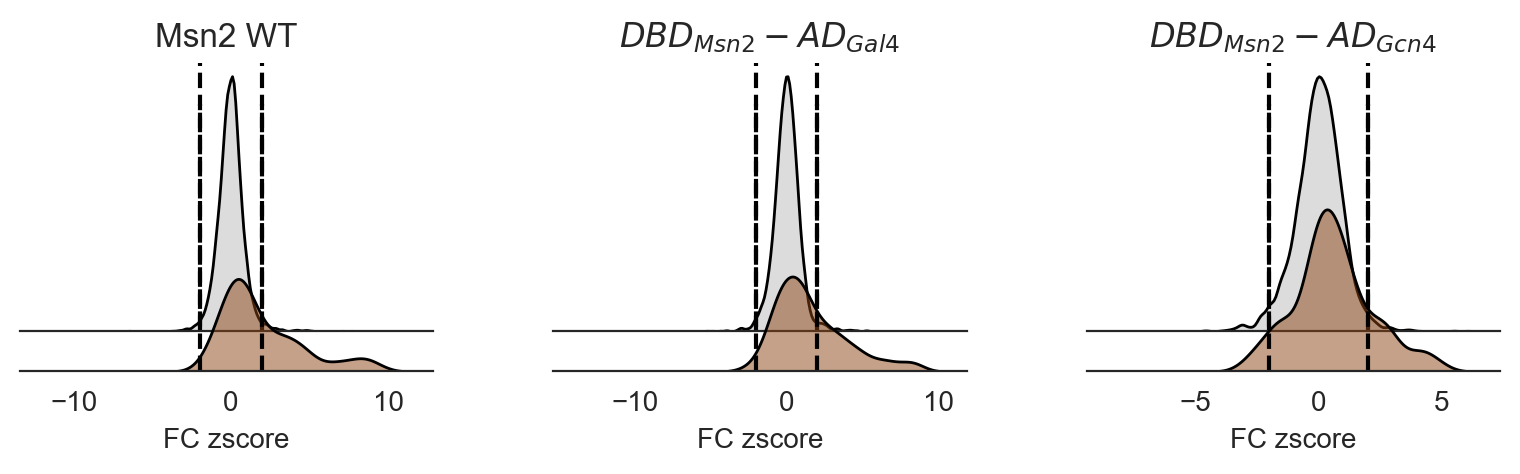

In [5]:
fig = plt.figure(figsize=(8,2))
subfigs = fig.subfigures(1,3)

axes = subfigs[0].subplots(2,1, sharex=True, sharey=True)
ax=axes.flatten()
activated = zs_fc_alltfs.Msn2Full_nodeletion_tef
kdeplot(ax, activated, wt_targets, 'Msn2 WT')


axes2 = subfigs[1].subplots(2,1, sharex=True, sharey=True)
ax=axes2.flatten()
activated = zs_fc_alltfs.Msn2DBDGal4AD_nodeletion_tef
kdeplot(ax, activated, wt_targets, r'$DBD_{Msn2}-AD_{Gal4}$')


axes3 = subfigs[2].subplots(2,1, sharex=True, sharey=True)
ax=axes3.flatten()
activated = zs_fc_alltfs.Msn2DBDGcn4AD_nodeletion_tef
kdeplot(ax, activated, wt_targets, r'$DBD_{Msn2}-AD_{Gcn4}$')


for axi in list(axes2.flatten())+list(axes.flatten())+list(axes3.flatten()):
    rect = axi.patch
    rect.set_alpha(0)
    axi.set_xlabel('FC zscore')
    axi.set_ylabel('')
    axi.set_yticklabels('')
    axi.axvline(2, c='k', linestyle='dashed')
    axi.axvline(-2, c='k', linestyle='dashed')


for i in [0,1,2]:
    sns.despine(subfigs[i],top=True,bottom=False, left=True)
    subfigs[i].subplots_adjust(hspace=-.85)




# fig.savefig('after_gm/fig1/exp_dists.pdf', bbox_inches = 'tight', transparent=True)

# Fig1F

C:\Users\vovam\AppData\Local\Temp\ipykernel_22492\998177712.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  secax.set_yticklabels(wt_targets.loc[[name + '_lab_data' for name in order]].applymap(lambda x:len(x)).WT.values)


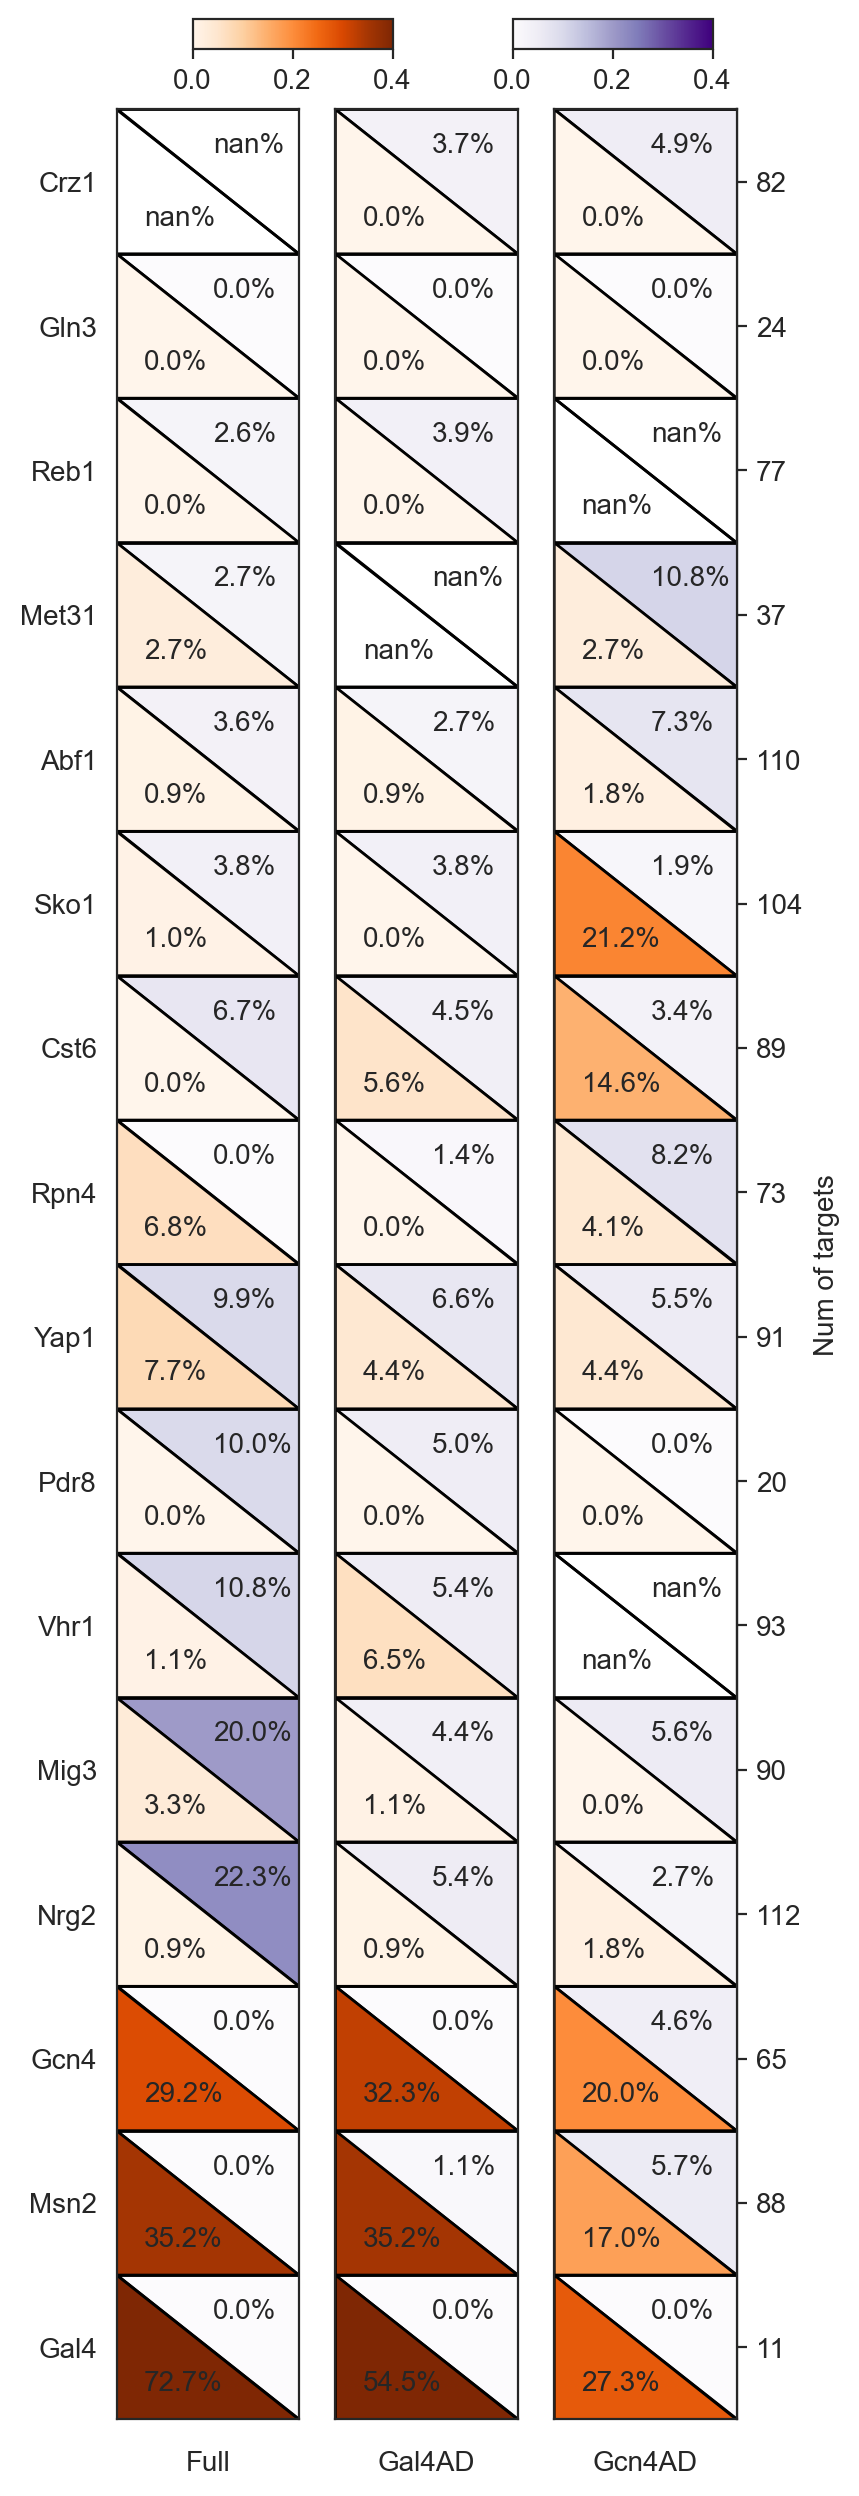

In [6]:
gal4ad_aff = defaultdict(dict)
gcn4ad_aff = defaultdict(dict)
full_aff = defaultdict(dict)

aff_list = [full_aff, gal4ad_aff, gcn4ad_aff]

for tf in all_tfs:
    curr_targets= wt_targets.filter(regex='^{}'.format(tf), axis=0).values[0][0]
    for i, var in enumerate(["Full", 'Gal4AD', 'Gcn4AD']):
        currzs = zs_fc_alltfs.filter(regex='^{}'.format(tf)).filter(regex=var)
        if nonlibs_tef_binding.filter(regex='^{}'.format(tf)).filter(regex=var).shape[1]!=0:
            aff_list[i][tf]['induced'] = ((currzs.loc[curr_targets]>=2).sum()/curr_targets.shape).values[0]
            aff_list[i][tf]['repressed'] = ((currzs.loc[curr_targets]<=-2).sum()/curr_targets.shape).values[0]
            

all_aff = pd.DataFrame(columns=all_tfs)
trail_df = pd.DataFrame(full_aff)
all_aff_df = pd.concat([all_aff, trail_df, pd.DataFrame(gal4ad_aff), pd.DataFrame(gcn4ad_aff)], axis=0)
all_aff_df = all_aff_df.sort_index(axis=1, ascending=True)
order = all_aff_df.iloc[[0,1]].max().sort_values(ascending=False).index
all_aff_df = all_aff_df.loc[:, order]

fig, ax = plt.subplots(1,3, figsize=(4,15))
triang(all_aff_df, fig)

# fig.savefig('newtext_figs/fig1/triangles_full.pdf', bbox_inches = 'tight', transparent=True)

# Supplementary

In [7]:
wt_tef_one = fg.get_targets_df(pd.concat([nonlibs_tef_binding_raw.filter(regex='Full'),
                                        lab_dat.Crz1_lab_data], axis=1).sort_index(axis=1),3,'WT',opn.loc[bins.index[:-1]], '')
wt_wt_one = fg.get_targets_df(lab_dat.sort_index(axis=1),3,'WT',opn.loc[bins.index[:-1]], '')

wt_tef_one.index = [name.split('_')[0].replace('Full', '') for name in wt_tef_one.index.values]
wt_wt_one.index = [name.split('_')[0].replace('Full', '') for name in wt_wt_one.index.values]

conc = pd.concat([wt_wt_one, wt_tef_one],axis=1)
conc.columns = ['wt', 'tef']
conc = pd.DataFrame(conc.applymap(lambda x: list(x)).sum(axis=1)).applymap(lambda x: pd.Index(x).drop_duplicates())
conc.columns=['wt']

dbd_ts = fg.get_targets_df(nonlibs_tef_binding_raw.filter(regex='DBD'),3,'dbd', opn.loc[bins.index[:-1]])
td = dict()
for i in all_tfs:
    for key, value in dbd_ts.filter(regex='^'+i, axis=0).to_dict()['dbd'].items():
        td.update(subset(conc.loc[i, 'wt'], {key:value}))
td_df = pd.DataFrame(td)

unique_both = pd.DataFrame(td_df.loc['unique']).copy()
unique_both.index = [name.split('DBD')[0] for name in td_df.columns.values]
ddup = lambda x: pd.Index(x).drop_duplicates()
dbd_unique_targets = unique_both.reset_index().groupby('index').sum().applymap(ddup)

dbdon = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Abf1',
 'Crz1',
 'Gln3',
 'Reb1',
 'Met31',
 'Rpn4',
 'Sko1',
 'Cst6']

C:\Users\vovam\AppData\Local\Temp\ipykernel_22492\998177712.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  secax.set_yticklabels(wt_targets.loc[[name + '_lab_data' for name in order]].applymap(lambda x:len(x)).WT.values)


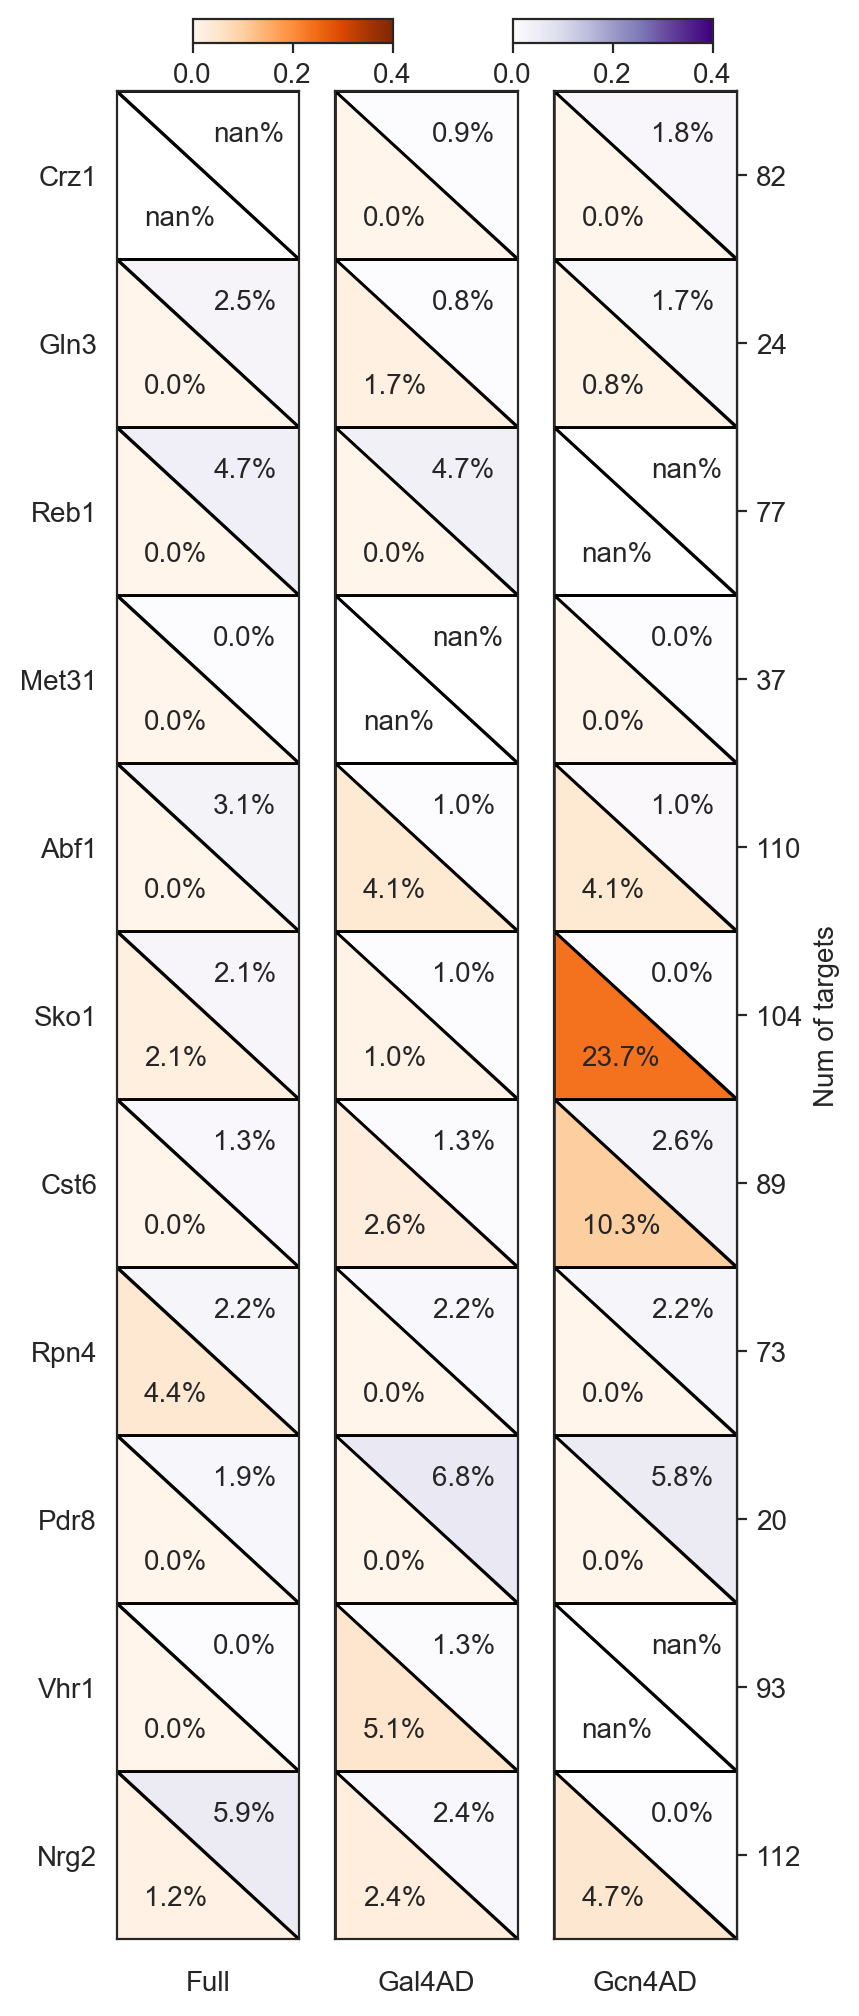

In [8]:
gal4ad_aff = defaultdict(dict)
gcn4ad_aff = defaultdict(dict)
full_aff = defaultdict(dict)

aff_list = [full_aff, gal4ad_aff, gcn4ad_aff]

for tf in dbdon:
    curr_targets= dbd_unique_targets.filter(regex='^{}'.format(tf), axis=0).values[0][0]
    for i, var in enumerate(["Full", 'Gal4AD', 'Gcn4AD']):
        currzs = zs_fc_alltfs.filter(regex='^{}'.format(tf)).filter(regex=var)
        if nonlibs_tef_binding.filter(regex='^{}'.format(tf)).filter(regex=var).shape[1]!=0:
            aff_list[i][tf]['induced'] = ((currzs.loc[curr_targets]>=2).sum()/curr_targets.shape).values[0]
            aff_list[i][tf]['repressed'] = ((currzs.loc[curr_targets]<=-2).sum()/curr_targets.shape).values[0]

order = [x for x in order if x in dbdon]
all_aff = pd.DataFrame(columns=dbdon)
trail_df = pd.DataFrame(full_aff)
all_aff_df = pd.concat([all_aff, trail_df, pd.DataFrame(gal4ad_aff), pd.DataFrame(gcn4ad_aff)], axis=0)
all_aff_df = all_aff_df.sort_index(axis=1, ascending=True)
all_aff_df = all_aff_df.loc[:, order]
fig, ax = plt.subplots(1,3, figsize=(4,12))
triang(all_aff_df, fig)
# fig.savefig('after_gm/fig1/triangles_dbds.pdf', bbox_inches = 'tight', transparent=True)